In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [5]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [6]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 10)
        )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.main(x)
        return nn.functional.log_softmax(x, dim=1)
        

In [7]:
discriminator = Discriminator().to(device)

In [8]:
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [11]:
# function to train the discriminator network
def train_discriminator(optimizer, data, labels):
    optimizer.zero_grad()
    output = discriminator(data)
    # print(output.shape)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    return loss, output

In [15]:
losses = []
accuracies = []
epochs = 50

discriminator.train()

for epoch in range(epochs):
    total = 0
    acc_loss = 0
    correct = 0
    for bi, (images, labels) in enumerate(data_loader):
        loss, output = train_discriminator(optim_d, images, labels)
        acc_loss += loss
        b_size = len(labels)
        total += b_size
        predicted = torch.argmax(output, dim=1)
        correct += (predicted==labels).sum()
        accuracy = correct/total
        avg_loss = loss/b_size
        if bi%20==0:
            print(f"Epoch {epoch}/{epochs}; Batch {bi}: Loss = {loss:.5f}\t\tAccuracy = {accuracy:.5f}")

    
    losses.append(acc_loss/total)
    accuracies.append(accuracy)


Epoch 0/50; Batch 0: Loss = 0.68056		Accuracy = 0.75977
Epoch 0/50; Batch 20: Loss = 0.58073		Accuracy = 0.76990
Epoch 0/50; Batch 40: Loss = 0.64883		Accuracy = 0.77449
Epoch 0/50; Batch 60: Loss = 0.57916		Accuracy = 0.78240
Epoch 0/50; Batch 80: Loss = 0.55576		Accuracy = 0.78725
Epoch 0/50; Batch 100: Loss = 0.54076		Accuracy = 0.78999
Epoch 1/50; Batch 0: Loss = 0.44395		Accuracy = 0.83984
Epoch 1/50; Batch 20: Loss = 0.54911		Accuracy = 0.82041
Epoch 1/50; Batch 40: Loss = 0.47042		Accuracy = 0.82136
Epoch 1/50; Batch 60: Loss = 0.45587		Accuracy = 0.82150
Epoch 1/50; Batch 80: Loss = 0.53354		Accuracy = 0.82497
Epoch 1/50; Batch 100: Loss = 0.50189		Accuracy = 0.82577
Epoch 2/50; Batch 0: Loss = 0.46958		Accuracy = 0.82812
Epoch 2/50; Batch 20: Loss = 0.41604		Accuracy = 0.83696
Epoch 2/50; Batch 40: Loss = 0.45875		Accuracy = 0.83694
Epoch 2/50; Batch 60: Loss = 0.46231		Accuracy = 0.83651
Epoch 2/50; Batch 80: Loss = 0.44729		Accuracy = 0.83789
Epoch 2/50; Batch 100: Loss = 0.

In [16]:
losses0 = [i.detach() for i in losses]

No handles with labels found to put in legend.


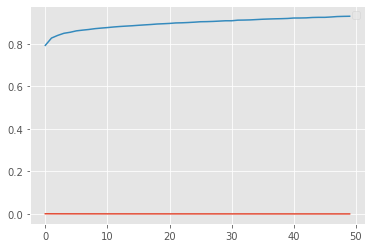

In [19]:
plt.figure()
plt.plot(losses0)
plt.plot(accuracies)
plt.legend()
plt.savefig('./outputs/loss_and_accuracy.png')

In [26]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [27]:
torch.save(discriminator.state_dict(), "./outputs/fmnist_classifier.pth")

In [29]:
# load model and set to evaluate mode

generator = Generator(nz)

generator.load_state_dict(torch.load("./generator.pth", map_location=torch.device('cpu')))
generator.eval()
print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [30]:
# generate 3,000 new images

sample_size = 3000

def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

nz = 128
# create noise
noise = create_noise(sample_size, nz)

# feed noise to generator
new_images = generator(noise)

# feed new images to discriminator
new_softmax = discriminator(new_images)
new_labels = torch.argmax(new_softmax, dim=1)

tensor([5, 4, 3,  ..., 1, 9, 6])

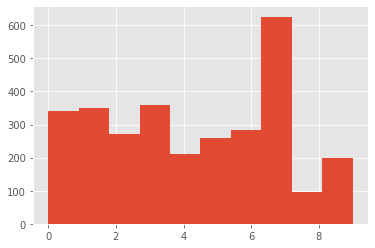

In [38]:
# plot histogram of labels

plt.figure()
plt.hist(new_labels.numpy(), bins=10)
# plt.legend()
plt.savefig("./outputs/new_labels_histogram.png")
plt.show()

(3000,)